In [2]:
import json
import re
from tqdm import tqdm
with open("./Accord_all_contract.json", "r") as f:
    templates = json.load(f)

In [3]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "deepset/roberta-base-squad2"

# a) Get predictions
nlp = pipeline('question-answering',
               model=model_name,
               tokenizer=model_name,
                  device=0,)
QA_input = {
    'question': 'Why is model conversion important?',
    'context': 'The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.'
}
res = nlp(QA_input)

# b) Load model & tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

2023-02-20 10:19:43.803818: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
with open("./templates_data.json", 'r') as f:
    templates_data = json.load(f)

In [5]:
data = {}
from urllib.parse import unquote
for k in set(templates.keys()).intersection(templates_data.keys()):
    data[k] = {
        "input_text": "".join(templates[k]['/text/sample.md']),
        "cicero": "".join(templates[k]['/text/grammar.tem.md']),
        "ciceroMarks": re.findall("(?<=\{{).+?(?=\}})", 
                         "".join(templates[k]['/text/grammar.tem.md'])),
        "QAs": [],
    }
    for variable_name, variable_value in templates_data[k].items():
        origin_value = variable_value
        if "$" == variable_name[0] or variable_name in ['clauseId', 'contractId']:
            continue
        try:
            try:
                variable_value = json.loads(variable_value.replace("'", '"'))
            except Exception as e:
#                 print(variable_value, e)
                pass
            if '.PostalAddress' in variable_value['$class']:
                continue
            for key in variable_value.keys():
                if 'text' in key.lower():
                    variable_value = variable_value['key']
                elif key in ['amount']:
                    if 'unit' in variable_value.keys():
                        variable_value = f"{variable_value[key]} {variable_value['unit']}"
                    else:
                        print("QQQQQQ", key , variable_value)
                    break
                elif 'value' in key.lower():
                    variable_value = f"{variable_value[key]} {variable_value['currencyCode']}"
                    break
                
            ans = variable_value
        except Exception as e:
            if variable_name == "termination":
                print(e)
            variable_value = str(variable_value)
            ans = unquote(variable_value.split(".")[-1].split("#")[-1])
        if type(ans) == dict:
            continue
        data[k]["QAs"].append({
            "variable_name": variable_name,
            "ans": ans,
            'variable_value': origin_value
        })

In [6]:
outputs = []
for k, v in tqdm(data.items()):
    for questions in v['QAs']:
        QA_input = {
            'context': v['input_text'],
            'question': f"What is the {questions['variable_name']}?",

        }
        res = nlp(QA_input)
        outputs.append({
            'score': res['score'],
            'model_output': res['answer']\
                            .replace(".00", "")\
                            .replace("\n", ""),
            'true_ans': questions['ans'],
            "k": k,
        })
#     break

  0%|                                   | 0/53 [00:00<?, ?it/s]/home/eason/anaconda3/envs/py37/lib/python3.7/site-packages/transformers/pipelines/base.py:1046: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
100%|██████████████████████████| 53/53 [00:25<00:00,  2.09it/s]


In [7]:
from utils import compute_exact_match, compute_f1

In [8]:
import numpy as np
all_f1 = []
all_em = []
for output in outputs:
    f1 = compute_f1(output['model_output'], output['true_ans'])
    em = compute_exact_match(output['model_output'], output['true_ans'])
    output['f1'] = f1
    output['em'] = em
    all_f1.append(f1)
    all_em.append(em)
all_f1 = np.array(all_f1)
all_em = np.array(all_em)

In [9]:
all_em.mean()

0.3248259860788863

In [10]:
all_f1.mean()

0.3950662476901047

In [11]:
import pandas as pd
df = pd.DataFrame(outputs)

In [12]:
df = df.sort_values('score', ascending=False)

In [13]:
df = df.reset_index(drop=True)

In [14]:
df[df.score > 0.3].em.mean()

0.6043956043956044

In [79]:
import math
from matplotlib import pyplot as plt
scores = {
    
}
for i in range(100):
    scores[i/100] = df[df.score > i/100].em.mean()
    if math.isnan(scores[i/100]) or scores[i/100] == 0:
        del scores[i/100]

([<matplotlib.axis.YTick at 0x7fa3f418aa90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

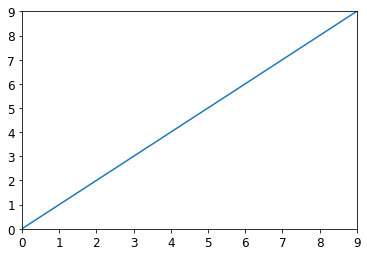

In [80]:
x = np.arange(0, 10, 1)
y =np.arange(0, 10, 1)
plt.margins(x=0, y=0)
plt.plot(x, y)
plt.xticks(x)
plt.yticks(y)

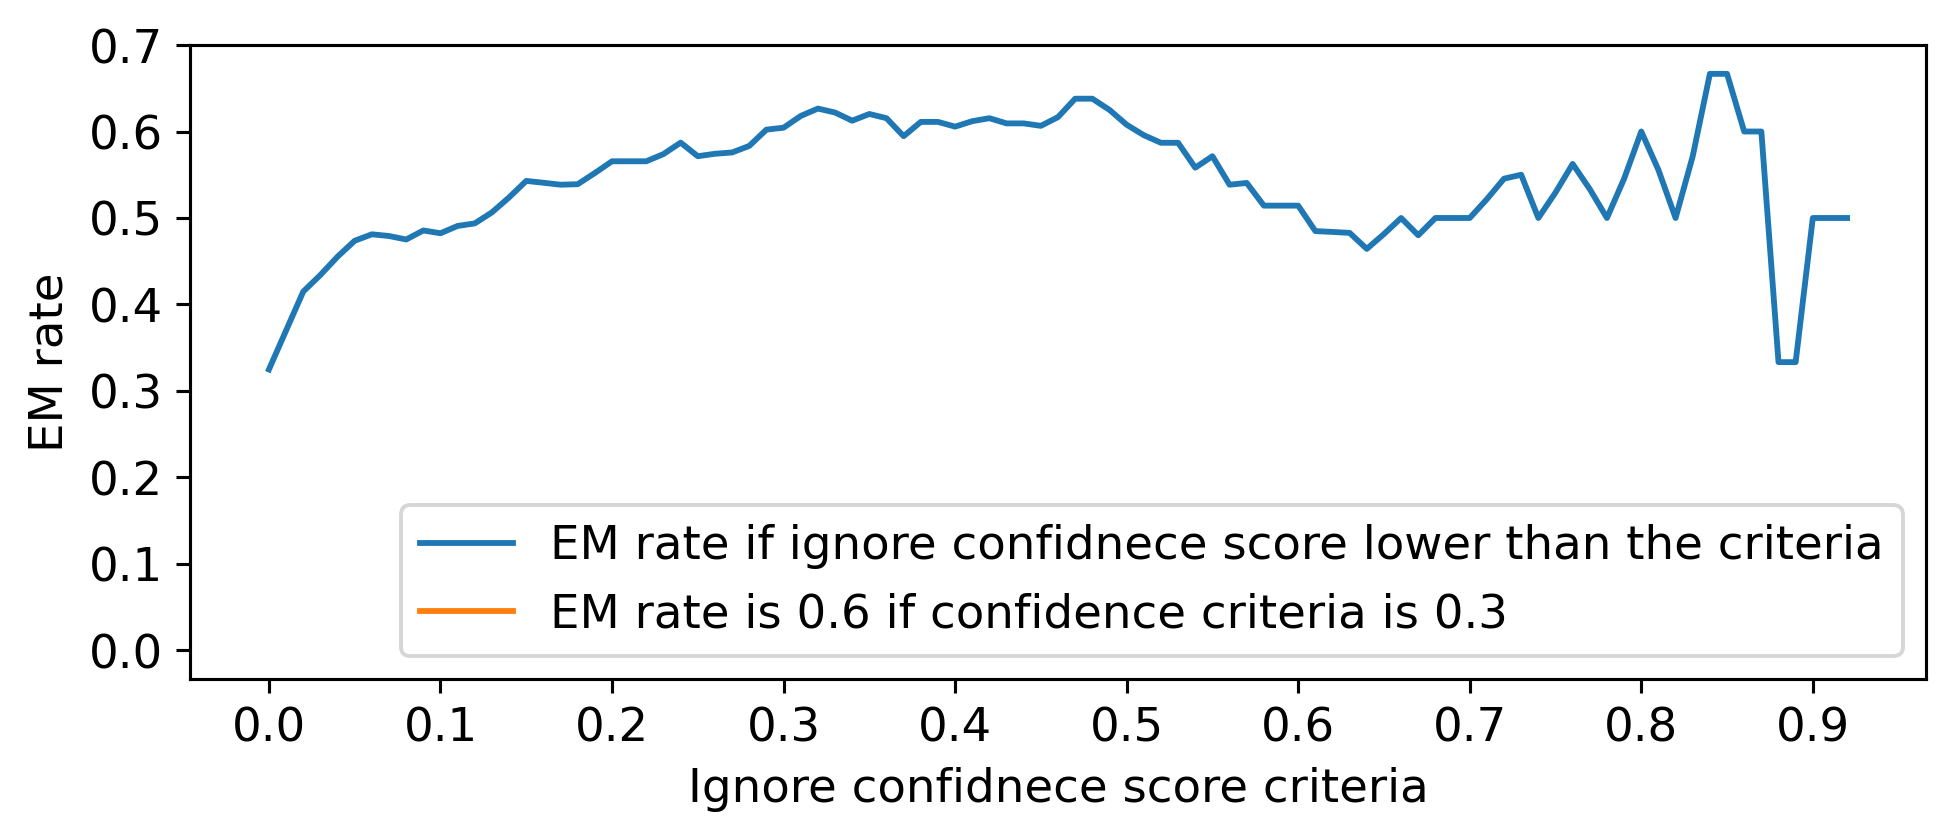

In [81]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
from matplotlib.pyplot import figure

figure(figsize=(8, 3), dpi=280)

x = np.arange(0, 11, 1)/10
y = np.arange(0, 11, 1)/10
plt.xticks(x)
plt.yticks(y)
plt.plot(scores.keys(), scores.values(), label = 'EM rate if ignore confidnece score lower than the criteria')
plt.plot(0, 0, label = 'EM rate is 0.6 if confidence criteria is 0.3')
# plt.scatter([0.3], scores[0.3], 5, color = 'red')
# plt.plot(scores.keys(), scores.keys(), label = 'Ignore confidnece score criteria')
plt.xlabel('Ignore confidnece score criteria')
plt.ylabel('EM rate')
plt.legend()
plt.show()

In [30]:
float(scores[0.99]) == float("nan")

False

0.6043956043956044

In [6]:
res

{'score': 0.31971532106399536,
 'start': 2454,
 'end': 2465,
 'answer': '1922.99 TRY'}

In [35]:
questions

{'variable_name': 'paymentPeriodWithPermission',
 'ans': '7 days',
 'variable_value': {'$class': 'org.accordproject.time.Duration',
  'amount': 7,
  'unit': 'days'}}

In [28]:
res

{'score': 0.000850165612064302,
 'start': 1244,
 'end': 1329,
 'answer': 'Licensee shall request permission from the governmental authority to make the payment'}

In [23]:
questions

{'variable_name': 'paymentPeriodWithPermission',
 'ans': '7 days',
 'variable_value': {'$class': 'org.accordproject.time.Duration',
  'amount': 7,
  'unit': 'days'}}

'supplier'

[{'variable_name': 'maximumDelay',
  'ans': '180 days',
  'variable_value': {'$class': 'org.accordproject.time.Duration',
   'amount': 180,
   'unit': 'days'}},
 {'variable_name': 'purchaser',
  'ans': 'Betty Buyer',
  'variable_value': 'resource:org.accordproject.party.Party#Betty%20Buyer'},
 {'variable_name': 'supplier',
  'ans': 'Steve Seller',
  'variable_value': 'resource:org.accordproject.party.Party#Steve%20Seller'}]

In [179]:
variable_value = QAs['latedeliveryandpenalty']["Qs"][-2]['variable_value']

In [180]:
QAs['latedeliveryandpenalty']["Qs"][-2]

{'variable_name': 'termination', 'ans': '15 days', 'variable_value': '15 days'}

In [171]:
variable_value = json.loads(variable_value.replace("'", '"'))
for key in variable_value.keys():
    if key in ['amount']:
        ans = f"{variable_value[key]} {variable_value['unit']}"
        break
    elif 'value' in key.lower():
        pass

AttributeError: 'dict' object has no attribute 'replace'

In [170]:
ans

'15 days'

In [134]:
QAs.keys()

dict_keys(['saft', 'payment-upon-signature', 'sales-contract-ru', 'certificate-of-incorporation', 'promissory-note', 'empty', 'payment-upon-delivery', 'acceptance-of-delivery', 'safte', 'empty-contract', 'latedeliveryandpenalty-currency-conversion', 'fragile-goods', 'minilatedeliveryandpenalty-capped', 'minilatedeliveryandpenalty-payment', 'promissory-note-md', 'latedeliveryandpenalty', 'servicelevelagreement', 'latedeliveryandpenalty-optional', 'supplyagreement-perishable-goods', 'full-payment-upon-demand', 'helloworldstate', 'one-time-payment-tr', 'car-rental-tr', 'perishable-goods', 'fixed-interests-static', 'simplelatedeliveryandpenalty', 'minilatedeliveryandpenalty', 'copyright-license', 'installment-sale', 'hellomodule', 'online-payment-contract-tr', 'payment-upon-iot', 'signature-block-title-name-date', 'demandforecast', 'fixed-interests', 'full-payment-upon-signature', 'contact-information', 'volumediscount', 'volumediscountulist', 'company-information', 'eat-apples', 'latedeli

In [109]:
variable_value

'16ddc768-3847-4fc6-a7e4-9b7d94c020dd'

'## Acceptance of Delivery.\n\n{{shipper}} will be deemed to have completed its delivery obligations\nif in {{receiver}}\'s opinion, the {{deliverable}} satisfies the\nAcceptance Criteria, and {{receiver}} notifies {{shipper}} in writing\nthat it is accepting the {{deliverable}}.\n\n## Inspection and Notice.\n\n{{receiver}} will have {{businessDays}} Business Days to inspect and\nevaluate the {{deliverable}} on the delivery date before notifying\n{{shipper}} that it is either accepting or rejecting the\n{{deliverable}}.\n\n## Acceptance Criteria.\n\nThe "Acceptance Criteria" are the specifications the {{deliverable}}\nmust meet for {{shipper}} to comply with its requirements and\nobligations under this agreement, detailed in {{attachment}}, attached\nto this agreement.'

In [93]:
variable_value

'16ddc768-3847-4fc6-a7e4-9b7d94c020dd'

In [73]:
variable_name, question

('shipper', 'resource:org.accordproject.organization.Organization#Party%20A')

In [78]:
v

{'$class': 'org.accordproject.acceptanceofdelivery.AcceptanceOfDeliveryClause',
 'shipper': 'resource:org.accordproject.organization.Organization#Party%20A',
 'receiver': 'resource:org.accordproject.organization.Organization#Party%20B',
 'deliverable': 'Widgets',
 'businessDays': 10,
 'attachment': 'Attachment X',
 'clauseId': '16ddc768-3847-4fc6-a7e4-9b7d94c020dd',
 '$identifier': '16ddc768-3847-4fc6-a7e4-9b7d94c020dd'}

'resource:org.accordproject.organization.Organization#Party A'

In [69]:
question.split("#")[1]

'Party%20A'

In [62]:
k

'acceptance-of-delivery'

In [8]:
data['latedeliveryandpenalty']['/text/sample.md']

['## Late Delivery and Penalty.\n',
 '\n',
 'In case of delayed delivery except for Force Majeure cases,\n',
 '"Dan" (the Seller) shall pay to "Steve" (the Buyer) for every 2 days\n',
 'of delay penalty amounting to 10.5% of the total value of the Equipment\n',
 'whose delivery has been delayed. Any fractional part of a days is to be\n',
 'considered a full days. The total amount of penalty shall not however,\n',
 'exceed 55% of the total value of the Equipment involved in late delivery.\n',
 'If the delay is more than 15 days, the Buyer is entitled to terminate this Contract.']

In [12]:
import re

In [38]:
res = re.findall("(?<=\{{).+?(?=\}})", 
                 "".join(data['latedeliveryandpenalty']['/text/grammar.tem.md']))

res

https://templates.accordproject.org/latedeliveryandpenalty@0.15.0.html

In [41]:
"".join(data['latedeliveryandpenalty']['/text/sample.md'])

'## Late Delivery and Penalty.\n\nIn case of delayed delivery except for Force Majeure cases,\n"Dan" (the Seller) shall pay to "Steve" (the Buyer) for every 2 days\nof delay penalty amounting to 10.5% of the total value of the Equipment\nwhose delivery has been delayed. Any fractional part of a days is to be\nconsidered a full days. The total amount of penalty shall not however,\nexceed 55% of the total value of the Equipment involved in late delivery.\nIf the delay is more than 15 days, the Buyer is entitled to terminate this Contract.'

In [40]:
"".join(data['latedeliveryandpenalty']['/text/grammar.tem.md'])

'## Late Delivery and Penalty.\n\nIn case of delayed delivery{{#if forceMajeure}} except for Force Majeure cases,{{/if}}\n{{seller}} (the Seller) shall pay to {{buyer}} (the Buyer) for every {{penaltyDuration}}\nof delay penalty amounting to {{penaltyPercentage}}% of the total value of the Equipment\nwhose delivery has been delayed. Any fractional part of a {{fractionalPart}} is to be\nconsidered a full {{fractionalPart}}. The total amount of penalty shall not however,\nexceed {{capPercentage}}% of the total value of the Equipment involved in late delivery.\nIf the delay is more than {{termination}}, the Buyer is entitled to terminate this Contract.'